# Оптимизация управление персоналом: анализ оттока сотрудников

HR-аналитика помогает бизнесу оптимизировать управление персоналом: аналитики предлагают, как избежать финансовых потерь и оттока сотрудников, на основании данных полученных от бизнеса. 


Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Сбор данных такими опросниками имеет некоторые сложности: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

Удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Цель:**
- на основе данных о сотрудниках предсказать возможность их оттока из компании и выделить основные признаки, влияющие на удовлетворённость сотрудника работой

**Задачи**:
1. построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2. построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


Для анализа и построения модели переданы по 3 таблицы для каждой задачи:

Для первой задачи:
- `train_job_satisfaction_rate.csv`: таблица с тренировочными данными, которая содержит характеристики сотрудников компании, а также данные об удовлетворенности работой.
- `test_features.csv`: таблица с данными для итогового тестирования модели с входными признаками (те же, что представлены в таблице для обучения модели, за исключенеим целевого признака - удовлетворенности). 
- `test_target_job_satisfaction_rate.csv`: таблица для итогового тестирования модели с данными об удовлетворенности сотрудников работой.

Для второй задачи:
- `train_quit.csv`: таблица с тренировочными данными, которая содержит характеристики сотрудников компании, а также данные об их увольнении из компании.
- `test_features.csv`: таблица с данными для итогового тестирования модели с входными признаками. Те же данные, что и для первой задачи.
- `test_target_quit.csv`: таблица для итогового тестирования модели с данными об увольнении сотрудников из компании.

Исследование пройдёт в несколько этапов *для каждой задачи*:
1. Обзор данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Обучение модели.
5. Интерпретация результатов и выводы.


## Задача 1: прогноз уровня удовлетворенности сотрудников
### 1.1 Обзор данных

In [1]:
! pip install shap -q
! pip install phik -q

In [2]:
#импортируем библиотеки
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder , StandardScaler, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import (mean_absolute_error, mean_squared_error , r2_score, recall_score, accuracy_score, precision_score, confusion_matrix, 
roc_auc_score, f1_score, make_scorer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
import phik
from scipy import stats as st
from phik.report import plot_correlation_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier
shap.initjs()
random_state = 42
sns.set_palette("pastel")

In [3]:
metrics=pd.DataFrame()
def clf_metrics(X_test, y_test,clf, name):
    
    """Эта функция проводит рассчитывает метрику ROC-AUC, 
     оценивающие качество и точность классификатора .

    На вход подаются входные данные и значения таргета из валидационной и тестовой выборок, классификатор, и его название или номер. 
    Функция выдает метрики в виде таблицы.
    """
    
    return pd.DataFrame({'clf' : [name],
                         'roc_auc_CV':[clf.best_score_], 
                         'roc_auc_test':[roc_auc_score(y_test, clf.best_estimator_.predict_proba(X_test)[:, 1])] 
                         })

In [4]:
#открываем файлы и записываем в переменные - столбцы разделены точкой с запятой, а числовые данные записаны с запятой
try:
    train_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test_X_satisfaction = pd.read_csv('/datasets/test_features.csv')
    test_y_satisfaction = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    train_satisfaction = pd.read_csv('train_job_satisfaction_rate.csv')
    test_X_satisfaction = pd.read_csv('test_features.csv')
    test_y_satisfaction = pd.read_csv('test_target_job_satisfaction_rate.csv')

In [5]:
train_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
train_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
train_satisfaction.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Таблица `train_satisfaction` представляет собой 4000 записей с характеристиками сотрудников компании. В таблице есть небольшое число пропусков в столбцах `dept` и `level`.

В таблице 10 столбцов:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.


In [8]:
test_X_satisfaction.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
916,480764,purchasing,junior,low,1,no,no,3,18000
1294,899770,sales,junior,high,2,no,no,4,37200
260,593398,sales,junior,medium,4,no,no,4,27600
110,826041,technology,junior,medium,2,no,no,5,32400
88,955747,purchasing,junior,medium,3,no,no,5,28800


In [9]:
test_X_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [10]:
test_X_satisfaction.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


В таблице `test_X_satisfaction` 2000 записей с теми же характеристиками сотрудников компании, что и в таблице `train_satisfaction` за исключением уровня удовлетворенности. В столбцах `dept` и `level` тоже есть единичные пропуски.

In [11]:
test_y_satisfaction.sample(5)

,id,job_satisfaction_rate
1835,520066,0.89
540,887100,0.11
1195,951029,0.67
1680,359268,0.37
1902,920112,0.61


In [12]:
test_y_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [13]:
test_y_satisfaction.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


В таблице `test_y_satisfaction` 2000 записей и представлены данные об удовлетворенности сотрудников. Без пропусков.

#### Вывод
 - Данные для первой задачи представлены в трех таблицах и соответствуют описанию задачи: в одной таблице данные для обучения модели, в остальных двух - для итогового тестирования качества модели.
 - В столбцах с входными признаками в столбцах `dept` и `level` есть несколько пропусков, которые заполним при подготовке данных непосредственно перед обучением модели с помощью SimpleImputer. 

### 1.2.Предобработка данных
#### 1.2.1 Пропуски

Немного детальнее посмотрим на пропуски:

In [14]:
train_satisfaction.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [15]:
train_satisfaction[train_satisfaction.dept.isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [16]:
train_satisfaction[train_satisfaction.level.isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [17]:
test_X_satisfaction.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [18]:
test_X_satisfaction[test_X_satisfaction.dept.isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [19]:
test_X_satisfaction[test_X_satisfaction.level.isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


- Данные об отделе отсутствуют у 6 сотрудников в тренировочной выборке, у 2 - в тестовой. Все эти сотрудники уровня junior.
- Данные об уровне занимаемой должности отсутствуют у 4 сотрудников в тренировочной выборке, у 1 - в тестовой. Все эти сотрудники работают в компании около года в отделе продаж.

#### 1.2.2 Дубликаты

- проверим на неявные дубликаты и ошибки

In [20]:
l = []
tables = [train_satisfaction, test_X_satisfaction]
for df in tables:
    data = pd.DataFrame()
    cat_cols = df.select_dtypes(exclude='number').columns
    for col in cat_cols:
        number = df[col].nunique()
        ar = df[col].unique()
        temp = pd.DataFrame({'column':[col],'nunique':[number],
                       'unique names':[ar]})
        data = data.append(temp)
    l.append(data)

In [21]:
l[0]

,column,nunique,unique names
0,dept,5,"[sales, hr, technology, purchasing, marketing,..."
0,level,3,"[junior, middle, sinior, nan]"
0,workload,3,"[medium, high, low]"
0,last_year_promo,2,"[no, yes]"
0,last_year_violations,2,"[no, yes]"


In [22]:
l[1]

,column,nunique,unique names
0,dept,6,"[marketing, hr, sales, purchasing, technology,..."
0,level,3,"[junior, middle, sinior, nan]"
0,workload,4,"[medium, low, high, ]"
0,last_year_promo,2,"[no, yes]"
0,last_year_violations,2,"[no, yes]"


Опечатка есть в колонке `level` старший специалист правильно пишется как senior. Исправим, чтобы работа была более грамотной.

In [23]:
for df in tables:
    df.level = df.level.replace('sinior', 'senior')

In [24]:
train_satisfaction.dept.unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [25]:
test_X_satisfaction.dept.unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [26]:
test_X_satisfaction.workload.unique()

array(['medium', 'low', 'high', ' '], dtype=object)

В таблице для теста есть пропуски, которые мы ранее не видели, так как они обозначены не с помощью nan, а через пробел. Их всего по одному в столбцах `workload` и `dept`. Заменим эти значения на nan.

In [27]:
test_X_satisfaction.workload.value_counts()

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

In [28]:
test_X_satisfaction.dept.value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

In [29]:
for col in ['workload', 'dept']:
    test_X_satisfaction[col] = test_X_satisfaction[col].replace(' ', np.nan)
    
test_X_satisfaction.isna().sum()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

- явные дубликаты

In [30]:
for df in tables:
    print(df.duplicated().sum())

0
0


In [31]:
for df in tables:
    print(df.duplicated(subset='id').sum())

0
0


Абсолютно одинаковых строчек в датасетах нет. Одинаковых id тоже нет

Если убрать id из сравнения то, имеем в тренировочных и тестовых данных значительное число повторяющихся строк.

Важно чтобы в тренировочных данных не было дубликатов, т.к. это может быть плохо для модели, уберем соответсвующие записи из выборки.

In [32]:
for df in tables:
    df = df.drop('id', axis=1)
    print(df.duplicated().sum())

245
557


In [33]:
shape_old = train_satisfaction.shape[0]
train_satisfaction = train_satisfaction.drop_duplicates(subset = train_satisfaction.drop(columns=['id']).columns)
shape_old - train_satisfaction.shape[0]

245

#### 1.2.3 Вывод
- Единичные пропуски присутствуют в данных тренировочной и тестовой выборки в столбцах `dept`, `level`, `workload`.
- Убрали опечатку в столбце `level`.
- Обнаружили 245 дубликатов записей в тренировочной датасете, их удалили.

### 1.3. Исследовательский анализ данных

In [34]:
train_satisfaction.describe(include='all')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3749,3751,3755,3755.000000,3755,3755,3755.000000,3755.000000,3755.000000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,NaN,1374,1699,1908,NaN,3635,3202,NaN,NaN,NaN
mean,543971.018642,NaN,NaN,NaN,3.817044,NaN,NaN,3.463648,34457.416778,0.532554
std,257519.882511,NaN,NaN,NaN,2.557142,NaN,NaN,1.026265,15050.643870,0.226393
min,100954.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.030000
25%,322889.500000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,0.350000
50%,532729.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,31200.000000,0.550000
75%,770477.500000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,44400.000000,0.710000


In [35]:
train_satisfaction.dtypes

id                         int64
dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo           object
last_year_violations      object
supervisor_evaluation      int64
salary                     int64
job_satisfaction_rate    float64
dtype: object

- Целевой признак `job_satisfaction_rate` непрерывная количественная переменная. `salary` тоже непрерывный количественный признак.
- `employment_years` - это дискретный количественный признак.
- `dept`, `last_year_promo`, `last_year_violations` относятся к категориальному типу.
- Признаки `level`, `workload`, `supervisor_evaluation` можно отнести к ранговому типу.

#### 1.3.1 Исследование количественных данных

Для количественных переменных построим гистограммы и ящики с усами.

Cоздадим две функции для визуализации количественных переменных.

In [36]:
def hist_for_nums(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.histplot(data = data[col], ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel('Число сотрудников')

In [37]:
def box_for_nums(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.boxplot(data = data[col].values, ax=ax)
        ax.set_title(col)
        ax.set_ylabel(col)

In [38]:
def count_for_cat(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.countplot(x=data[col], data=data, order=data[col].value_counts().index, ax=ax)
        ax.set_title(col)
        ax.set_ylabel('Число сотрудников')
        for i, v in enumerate(data[col].value_counts()):
            ax.text(i, v, str(v), ha='center')

**Тренировочная выборка:**

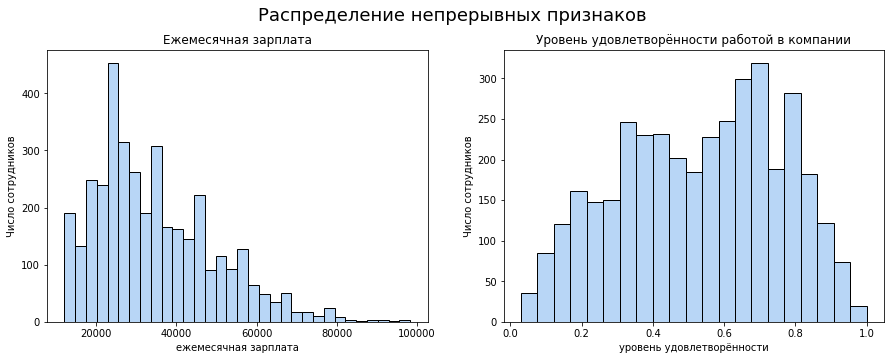

In [39]:
num_cols = ['salary', 'job_satisfaction_rate']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Распределение непрерывных признаков' , fontsize=18,  y=1)
hist_for_nums(train_satisfaction, num_cols)

axs[0].set_title("Ежемесячная зарплата")
axs[0].set_xlabel('ежемесячная зарплата')

axs[1].set_title("Уровень удовлетворённости работой в компании")
axs[1].set_xlabel('уровень удовлетворённости');

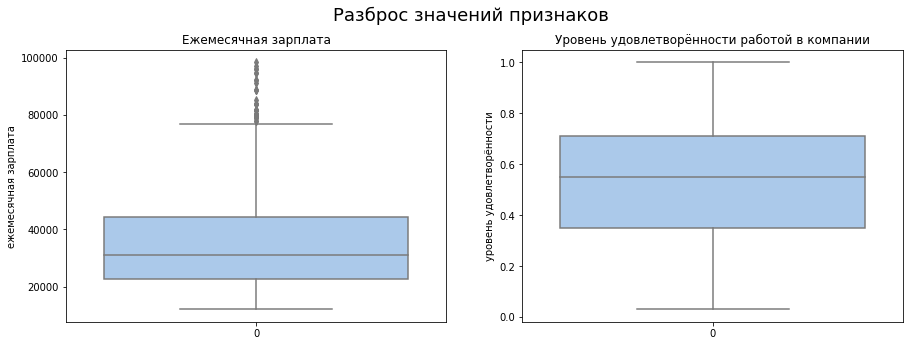

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Разброс значений признаков' , fontsize=18,  y = 1)
box_for_nums(train_satisfaction, num_cols)

axs[0].set_title("Ежемесячная зарплата")
axs[0].set_ylabel('ежемесячная зарплата')

axs[1].set_title("Уровень удовлетворённости работой в компании")
axs[1].set_ylabel('уровень удовлетворённости');

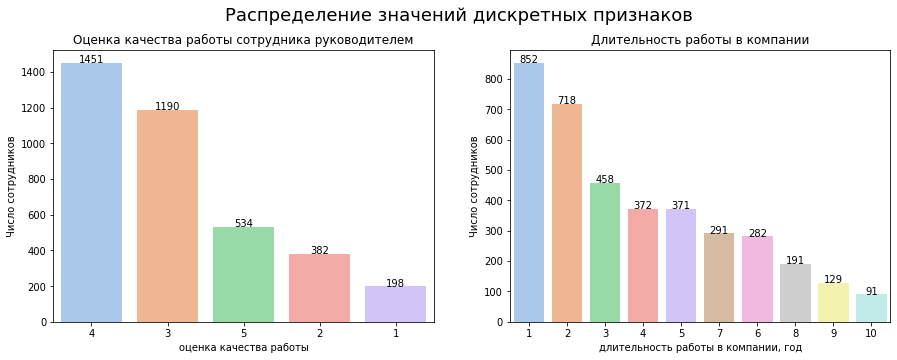

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Распределение значений дискретных признаков' , fontsize=18,  y = 1)

count_for_cat(train_satisfaction, ['supervisor_evaluation', 'employment_years'])

axs[1].set_title("Длительность работы в компании")
axs[1].set_xlabel("длительность работы в компании, год")

axs[0].set_title("Оценка качества работы сотрудника руководителем")
axs[0].set_xlabel('оценка качества работы');

- В компании больше новых сотрудников (работают 1-3 года), нежели сотрудников-"старожилов" (6-10 лет в компании)
- Большинство сотрудников работают удовлитворительно (оценка 3) или хорошо (оценка 4) по мнению руководителей. Меньше всего сотрудников, которых руководитель оценил минимально по шкале от 1 до 5.
- Большинство сотрудников получают зарплату в размере 20-40 тыс.
- Уровень удовлетворенности сотрудников в среднем составляет около 0.6. 

**Тестовая выборка:**

Text(0.5, 0, 'оценка качества работы')

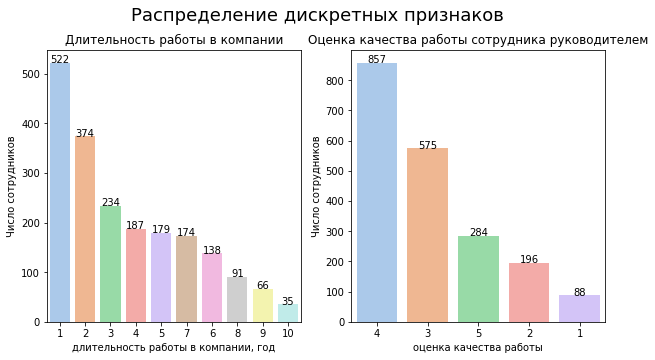

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('Распределение дискретных признаков' , fontsize=18,  y=1)

count_for_cat(test_X_satisfaction, ['employment_years', 'supervisor_evaluation'])

axs[0].set_title("Длительность работы в компании")
axs[0].set_xlabel("длительность работы в компании, год")

axs[1].set_title("Оценка качества работы сотрудника руководителем")
axs[1].set_xlabel('оценка качества работы')

Text(0, 0.5, 'ежемесячная зарплата')

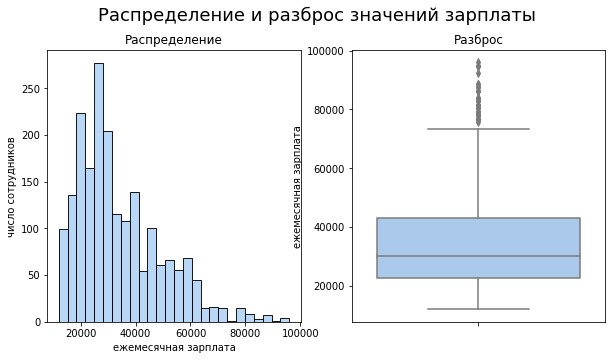

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('Распределение и разброс значений зарплаты' , fontsize=18,  y = 1)

sns.histplot(x=test_X_satisfaction['salary'], ax=axs[0])
axs[0].set_title("Распределение")
axs[0].set_xlabel('ежемесячная зарплата')
axs[0].set_ylabel('число сотрудников')

sns.boxplot(y=test_X_satisfaction.salary, ax=axs[1])
axs[1].set_title("Разброс")
axs[1].set_ylabel('ежемесячная зарплата')

- Закономерности распределения и разброса входных признаков в тестовой выборке похожи на те, что мы видели для тренировочной выборки.

#### 1.3.2 Исследование категориальных данных

Для категориальных сделаем столбчатые диаграммы.

**Тренировочная выборка**:

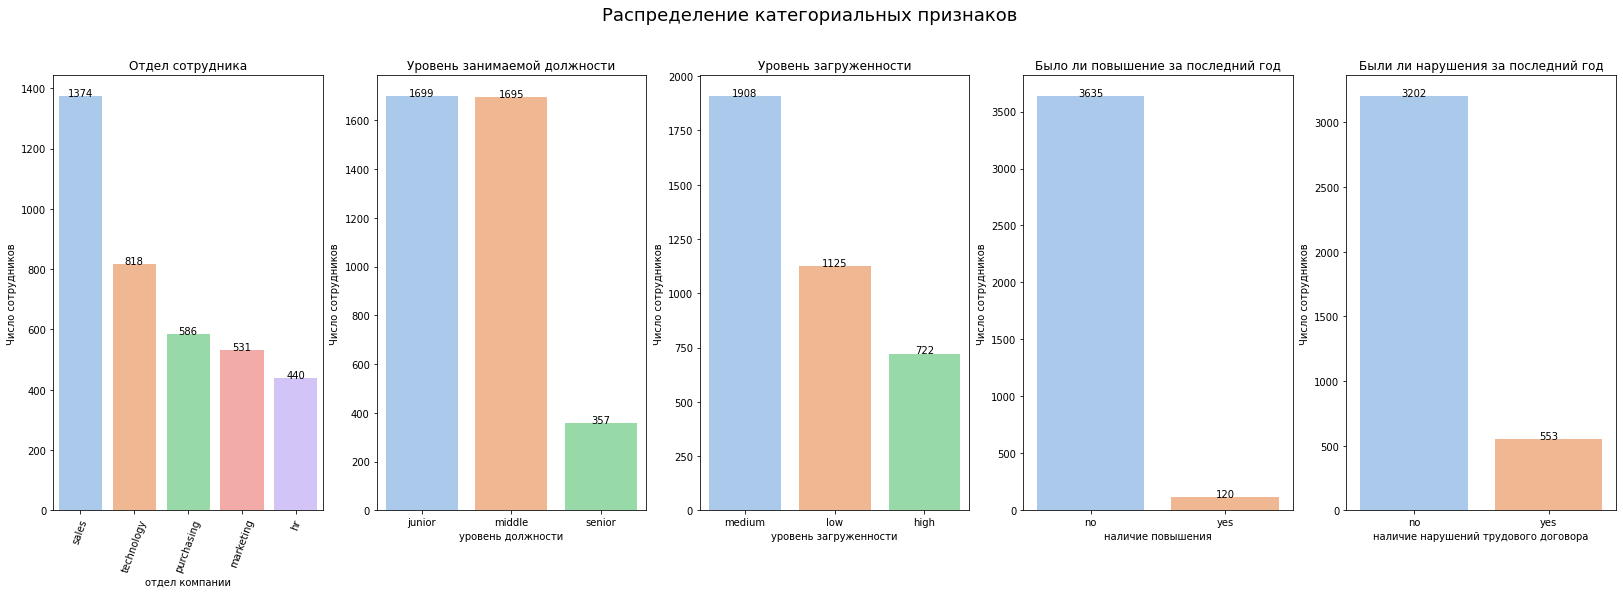

In [44]:
cat_cols = train_satisfaction.select_dtypes(exclude='number').columns
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(28, 8))
fig.suptitle('Распределение категориальных признаков' , fontsize=18,  y = 1)
count_for_cat(train_satisfaction, cat_cols)
axs[0].set_xticklabels(train_satisfaction['dept'].value_counts().index,rotation=70);
axs[0].set_title("Отдел сотрудника")
axs[0].set_xlabel("отдел компании")

axs[1].set_title("Уровень занимаемой должности")
axs[1].set_xlabel('уровень должности')

axs[2].set_title("Уровень загруженности")
axs[2].set_xlabel('уровень загруженности')

axs[3].set_title("Было ли повышение за последний год")
axs[3].set_xlabel('наличие повышения')

axs[4].set_title("Были ли нарушения за последний год")
axs[4].set_xlabel('наличие нарушений трудового договора');

Большая часть сотрудников:
- работают в отделе продаж и в технологической отделе;
- занимают junior или middle должность;
- имеют средний или низкий уровень загруженности

Абсолютное большинство не получило повышение за последний год и не нарушало трудовой договой. По этим признакам получаются очень несбалансированные группы.

**Тестовая выборка:**

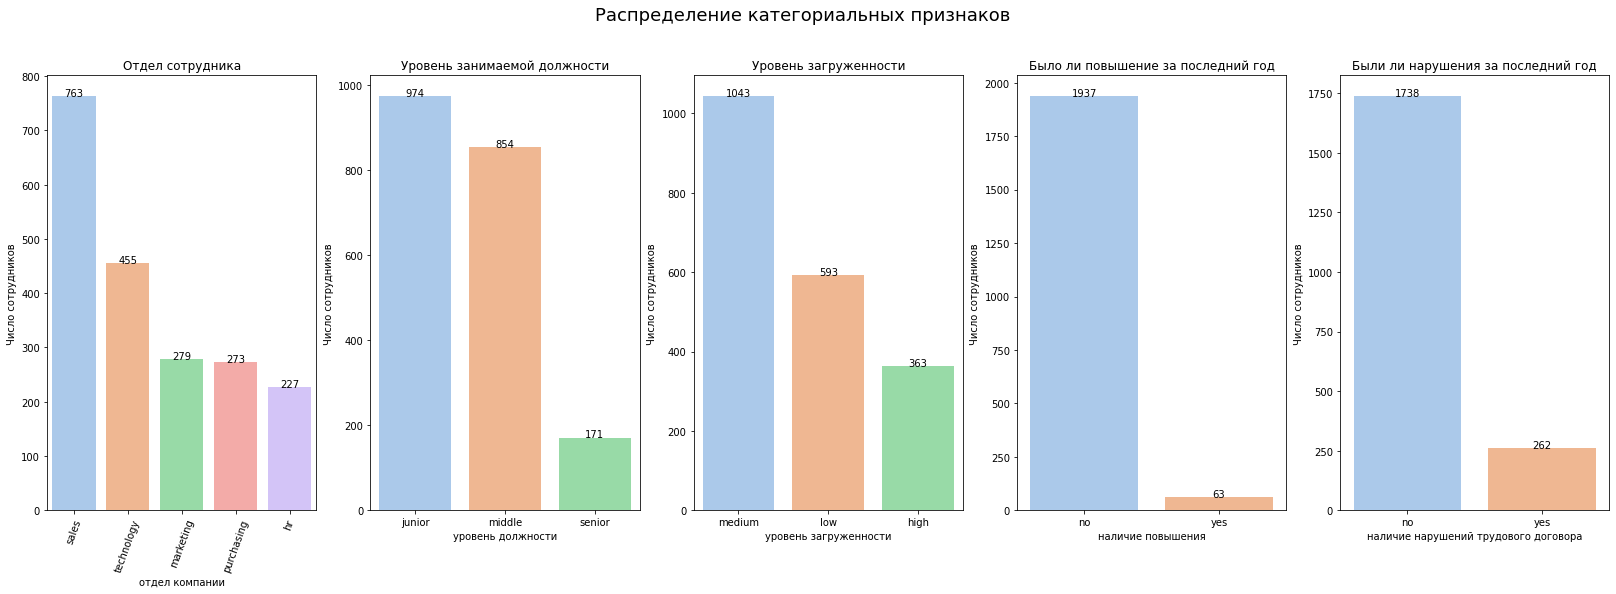

In [45]:
cat_cols = test_X_satisfaction.select_dtypes(exclude='number').columns
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(28, 8))
fig.suptitle('Распределение категориальных признаков' , fontsize=18,  y = 1)
count_for_cat(test_X_satisfaction, cat_cols)
axs[0].set_xticklabels(test_X_satisfaction['dept'].value_counts().index,rotation=70);
axs[0].set_title("Отдел сотрудника")
axs[0].set_xlabel("отдел компании")

axs[1].set_title("Уровень занимаемой должности")
axs[1].set_xlabel('уровень должности')

axs[2].set_title("Уровень загруженности")
axs[2].set_xlabel('уровень загруженности')

axs[3].set_title("Было ли повышение за последний год")
axs[3].set_xlabel('наличие повышения')

axs[4].set_title("Были ли нарушения за последний год")
axs[4].set_xlabel('наличие нарушений трудового договора');

- Закономерности распределения сотрудников по категориям в тестовой выборке похожи на те, что мы видели для тренировочной выборки.

#### 1.3.3 Вывод
- Все признаки распределены реалистично. Аномалий и выбросов не обнаружено.
- В компании много новых сотрудников (работают 1-3 года), и сильно меньше сотрудников-"старожилов" (6-10 лет в компании)
- Большинство сотрудников работают удовлитворительно (оценка 3) или хорошо (оценка 4) по мнению руководителей. Меньше всего сотрудников, которых руководитель оценил минимально по шкале от 1 до 5.
- Большинство сотрудников получают зарплату в размере 20-40 тыс.
- Уровень удовлетворенности сотрудников в среднем составляет около 0.6. 
- Большая часть сотрудников работают в отделе продаж или в технологической отделе, занимают junior или middle должность, а также имеют средний или низкий уровень загруженности.
- Распределение категориальных и количественных данных имеет схожие паттерны в тестовой и тренировочной выборках, что благоприятно для построения качественной модели.

- Чтобы подготовить данные к обучению, количественые признаки будем масштабировать (StandartScaler, MinMaxScaler), , бинарные категориальные признаки обработаем с помощью OHEncoder, для остальных категориальных и для ранговых перменных воспользуемся OrdinalEncoder. Для ранговых признаков учтем порядок при кодировании.

### 1.4. Корреляционный анализ

Рассмотрим корреляцию признаков. Применим корреляцию Фи, чтобы увидеть закономерности между всеми признаками.

In [46]:
corr_matrix = train_satisfaction.drop(columns='id').phik_matrix(interval_cols=num_cols)

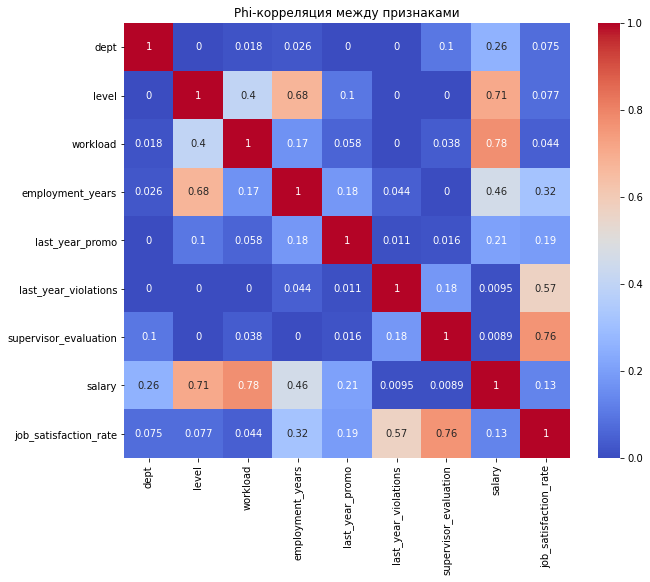

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi-корреляция между признаками')
plt.show();

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


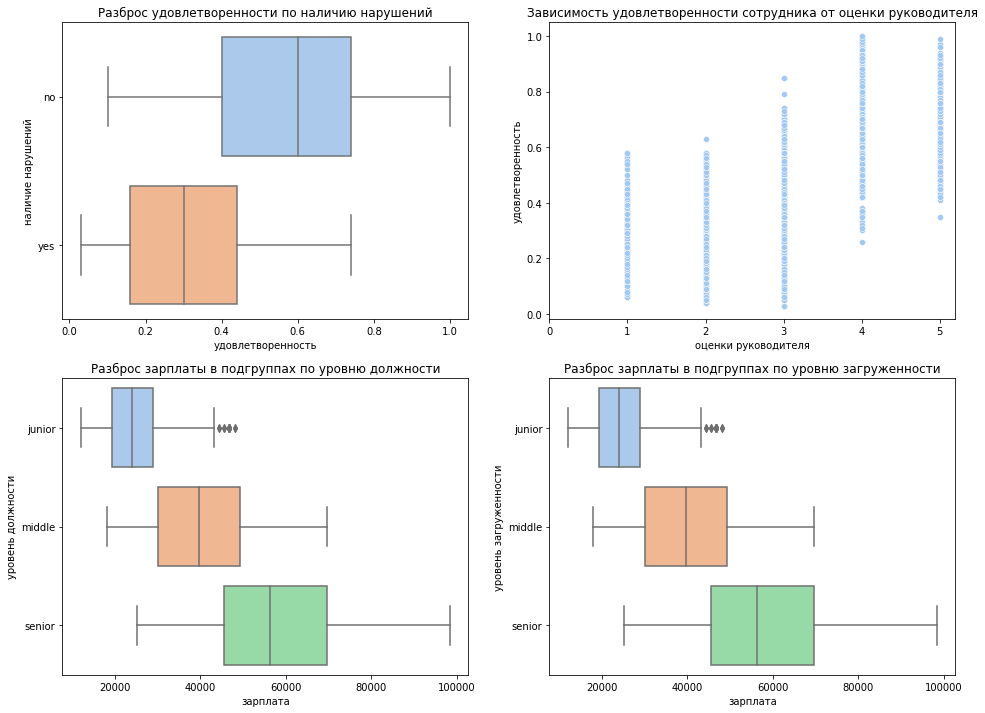

In [48]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
sns.boxplot(data=train_satisfaction, x="job_satisfaction_rate", y="last_year_violations", ax=axs[0,0])
axs[0,0].set_ylabel('наличие нарушений')
axs[0,0].set_xlabel('удовлетворенность')
axs[0,0].set_title('Разброс удовлетворенности по наличию нарушений')

sns.scatterplot(data=train_satisfaction, y="job_satisfaction_rate", x="supervisor_evaluation", ax=axs[0,1])
axs[0,1].set_ylabel('удовлетворенность')
axs[0,1].set_xlabel('оценки руководителя')
axs[0,1].set_title('Зависимость удовлетворенности сотрудника от оценки руководителя')
axs[0,1].set_xticks(range(5), [1,2,3,4,5]) 

sns.boxplot(data=train_satisfaction, x="salary", y="level", ax=axs[1,0])
axs[1,0].set_xlabel('зарплата')
axs[1,0].set_ylabel('уровень должности')
axs[1,0].set_title('Разброс зарплаты в подгруппах по уровню должности')


sns.boxplot(data=train_satisfaction, x="salary", y="level", ax=axs[1,1])
axs[1,1].set_xlabel('зарплата')
axs[1,1].set_ylabel('уровень загруженности')
axs[1,1].set_title('Разброс зарплаты в подгруппах по уровню загруженности');

- Между признаками нет мультиколлинеарности.
- Есть значительная зависимость между зарплатой и уровнем занимаемой должности и уровнем загруженности. Чем ниже уровень должности и загруженности, тем меньше зарплата.
- Удовлетворенность зависит от оценки работы сотрудника руководителем и от наличия нарушений трудового договора. Если сотрудник недоволен, он скорее будет нарушать трудовой договор. Если сотрудник доволен, то и руководитель скорее всего доволен работой сотрудника.
- Кроме того, зарплата умеренно зависит от количества лет проработанных в компании.
- От количества проработанных в компании лет также зависит уровень занимаемой должности. Со временем уровень занимаемой должности повышают.

#### Вывод
- Мультиколлинеарных признаков нет.
- Зарплата положительно зависит от уровня занимаемой должности и уровня загруженности.
- Удовлетворенный сотрудник реже нарушает трудовой договор и его работа положительно оценивается руководителем.

### 1.5. Построение модели 
Задача 1 - построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Это задача регресии.

Таргет - уровень удовлетворённости сотрудника.

Входные признаки - все остальные представленные в таблице `train_satisfaction` (кроме id).

Сначала создадим пайплайн для подготовки данных, затем - итоговый пайплайн включающий модель.

Для бинарных категориальных признаков применим OHE, для отдела сотрудника и ранговых признаков применим - OrdinalEncoder. Масштабировать количественные данные будем с помощью StandardScaler или MinMaxScaler. Кроме того, заменим пропуски на самые распространенные значения с помощью SimpleImputer.

Для решения задачи регрессии ипользуем линейнуюю регрессию, регрессионное дерево решений и случайный лес. Подберем из них более подходящую модель, также подберем лучшие (обеспечтвающие лучшее качество) гиперпараметры для избранной модели. 

Для оценки качества будем пользоваться своей метрикой SMAPE (symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»):

**SMAPE = 100/n Σn i=1 |y_test - y_pred|/(|y_test| + |y_pred|)/2,**

где:
- n - количество объектов в выборке;
- y_test - фактическое значение целевого признака для объекта;
- y_pred - предсказанное значение целевого признака для объекта

Критерий успеха: SMAPE ≤15 на тестовой выборке.

#### 1.5.1 Подготовка данных

1. Создадим функцию

In [49]:
# создаём функцию для оценки качества модели -  аргументы y_true, y_pred
def smape(y_test, y_pred):
    metric = np.mean((abs(y_test - y_pred)/((abs(y_test)+abs(y_pred))/2)))*100
    return metric

# создаём пользовательскую метрику
# используем greater_is_better=False
smape_score = make_scorer(smape, greater_is_better=False)

2. Подготовим пайплайн для подготовки данных и обучения
- пайплайн для подготовки порядковых/ранговых признаков

In [50]:
train_satisfaction.sample()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3367,185080,sales,middle,medium,6,no,yes,4,33600,0.53


In [51]:
ohe_columns = ['last_year_promo','last_year_violations']
rang_ord_columns = ['level', 'workload']
ord_columns = ['dept']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation']

In [52]:
# SimpleImputer + ORD

rang_ord_pipe = Pipeline(
    [
        (
            'imputer', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan)
            
        ),
        (
            'imputer_after', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ])

- пайплайн для подготовки небинарных категориальных данных - колонка dept, есть пропуски

In [53]:
ord_pipe = Pipeline(
    [
        (
            'imputer', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'imputer_after', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
        
    ]
)

In [54]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('rang_ord',rang_ord_pipe, rang_ord_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

- итоговый пайплайн: подготовка данных и модель

In [55]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

#### 1.5.2 Базовая модель
- обучим базовую модель:

In [56]:
X_train = train_satisfaction.drop(columns=['id', 'job_satisfaction_rate'])
y_train = train_satisfaction.job_satisfaction_rate
# обучаем модель на тренировочной выборке
pipe_final.fit(X_train, y_train)


Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
       

Так как наша метрика показывает ошибку и мы установили параметр greater_is_better=False, функция make_scorer() поменяет знак значения функции на противоположный.
#### 1.5.3 Поиск лучшей модели

In [57]:
param_distributions = [
    {
        # название модели
        'models': [Ridge(random_state=random_state)],
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']   
    },
    {
        # название модели
        'models': [Lasso(random_state=random_state)],
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']   
    },
    {
        # название модели
        'models': [ElasticNet(random_state=random_state)],
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']   
    },
    {
        'models': [DecisionTreeRegressor(random_state=random_state)],
        'models__max_depth': range(2,15),
        'models__min_samples_split': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [RandomForestRegressor(random_state=random_state)],
        'models__n_estimators': range(10, 150),
        'models__max_depth': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [58]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring=smape_score, 
    random_state=random_state,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
            

In [59]:
print('Метрика SMAPE для лучшей модели:\n', abs(randomized_search.best_score_))
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика SMAPE для лучшей модели:
 13.81493205839418

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                         

Лучшая модель (в нашем случае ансамбль моделей) - случайный лес с параметрами max_depth=14, min_samples_split=4, n_estimators=125. Масштабирование с помощью StandardScaler. 

Значение sMAPE удовлетворяющее.

**Метрика на тестовой выборке:**

In [60]:
test = test_y_satisfaction.merge(test_X_satisfaction, on ='id')

In [61]:
test.shape

(2000, 10)

In [62]:
abs(smape_score(randomized_search.best_estimator_, test.drop(['id', 'job_satisfaction_rate'], axis=1),test.job_satisfaction_rate))

12.474859998363954

In [63]:
best_reg = randomized_search.best_estimator_

Метрика соответсвует критерию успеха! Значит качество нашей модели удовлетворительно для данной задачи.

**Проверим лучшую модель на адекватность:**

In [64]:
pipe_dummy = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DummyRegressor(strategy="mean"))
    ]
)

In [65]:
pipe_dummy.fit(X_train, y_train)

abs(smape_score(pipe_dummy, test.drop(['id', 'job_satisfaction_rate'], axis=1),test.job_satisfaction_rate))

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


38.26225790202237

Ошибка DummyRegressor больше, чем в нашей лучшей модели. Значит лучшая модель небесполезна.

Еще посмотрим на **важность признаков** при определении уровня удовлетворенности сотрудников:

In [66]:
columns = ['last_year_promo', 'last_year_violations','dept', 'level', 'workload', 'employment_years', 'salary', 'supervisor_evaluation'] 

In [67]:
X_train_processed =randomized_search.best_estimator_['preprocessor'].transform(X_train)                                                                           
permutation = permutation_importance(randomized_search.best_estimator_['models'], X_train_processed, y_train,scoring = smape_score)

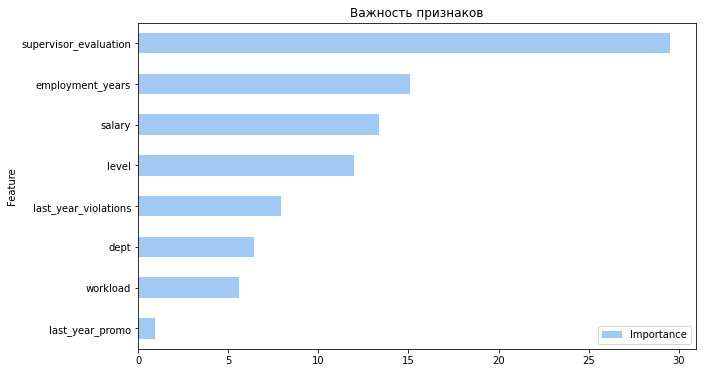

In [68]:
feature_importance = pd.DataFrame({'Feature': columns, 'Importance': permutation['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Важность признаков');

Самый значимый признак - оценка руководителя. Далее по важности следуют - количество лет в компании, зарплата.

In [69]:
model = randomized_search.best_estimator_['models']
X_train_processed = pd.DataFrame(X_train_processed, columns=columns)
X_test_processed = randomized_search.best_estimator_["preprocessor"].transform(test_X_satisfaction.drop(columns=['id']))
X_test_processed = pd.DataFrame(X_test_processed, columns=columns)

In [70]:
X_train_processed.sample()

,last_year_promo,last_year_violations,dept,level,workload,employment_years,salary,supervisor_evaluation
854,0.0,0.0,4.0,0.0,2.0,-0.710671,0.261989,-0.451843


In [71]:
explainer1 = shap.KernelExplainer(model.predict, X_train_processed.sample(100))

In [72]:
shap_values = explainer1(X_test_processed[:30])

  0%|          | 0/30 [00:00<?, ?it/s]

Посмотрим важность признаков:

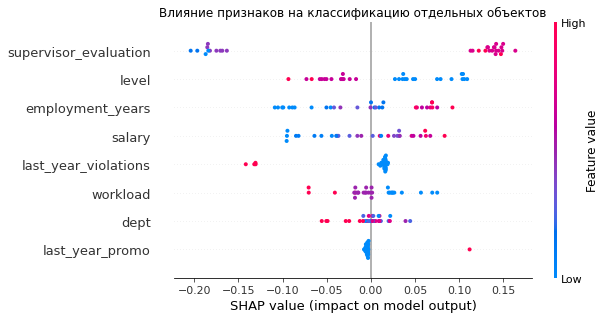

In [73]:
plt.title('Влияние признаков на классификацию отдельных объектов')
shap.plots.beeswarm(shap_values, max_display=16) 

Удовлетворенность сотрудника работой в компании выше, если:
- его хорошо оценивает руководитель
- он уже долго работает в компании
- получает не самую низкую зарплату
- имеет невысокую загруженность
- получает повышение

#### 1.5.4 Вывод
- Лучше всего с задачей справился ансамблю моделей RandomForest с параметрами max_depth=14, min_samples_split=4, n_estimators=125 и методом масштабирования StandardScaler. 
- SMAPE на валидационной выборке равна 13.8, на тестовой - равна 12.5.
- Наиболее важные признаки, влияющие на прогнозирование - оценка работы сотрудника руководителем, количество лет в компании, зарплата.

## Задача 2: предсказание увольнения сотрудника из компании

Тренировочная выборка - те же входные признаков (другие значения), но другой таргет - увольнение из компании в файле train_quit.csv

Входные признаки тестовой выборки те же, что и в прошлой задаче - таблица test_X_satisfaction (из задачи 1)

Целевой признак тестовой выборки в файле test_target_quit.csv

In [74]:
#открываем файлы и записываем в переменные 
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    test_y_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    train_quit = pd.read_csv('train_quit.csv')
    test_y_quit = pd.read_csv('test_target_quit.csv')

In [75]:
train_quit.sample(5)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2685,165841,purchasing,middle,medium,6,no,no,5,45600,no
3198,657880,technology,middle,high,6,no,no,4,63600,no
168,391260,marketing,middle,medium,6,no,no,4,36000,no
1699,229361,purchasing,middle,low,4,no,no,2,27600,no
2563,843790,purchasing,sinior,low,1,no,no,3,25200,yes


In [76]:
test_y_quit.sample(5)

,id,quit
1969,801477,no
1586,275269,yes
1679,820105,no
169,273718,no
1638,126054,no


### 2.1 Предобработка данных
#### 2.1.1 Пропуски

Немного детальнее посмотрим на пропуски:

In [77]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Пропусков нет.

#### 2.1.2 Дубликаты

- проверим на неявные дубликаты и ошибки

In [78]:
l = []
tables = [train_quit]
for df in tables:
    data = pd.DataFrame()
    cat_cols = df.select_dtypes(exclude='number').columns
    for col in cat_cols:
        number = df[col].nunique()
        ar = df[col].unique()
        temp = pd.DataFrame({'column':[col],'nunique':[number],
                       'unique names':[ar]})
        data = data.append(temp)
    l.append(data)

In [79]:
l[0]

,column,nunique,unique names
0,dept,5,"[sales, purchasing, marketing, technology, hr]"
0,level,3,"[middle, junior, sinior]"
0,workload,3,"[high, medium, low]"
0,last_year_promo,2,"[no, yes]"
0,last_year_violations,2,"[no, yes]"
0,quit,2,"[no, yes]"


Опечатка есть в колонке `level` старший специалист правильно пишется как senior. Исправим, чтобы работа была более грамотной.

In [80]:
for df in tables:
    df.level = df.level.replace('sinior', 'senior')

- строки-дубликаты

In [81]:
train_quit.drop(columns=['id']).duplicated().sum()

1413

In [82]:
shape_old = train_quit.shape[0]
train_quit = train_quit.drop_duplicates(subset = train_quit.drop(columns=['id']).columns)
shape_old - train_quit.shape[0]

1413

#### 2.1.3 Вывод
Проверили все как и в первой задаче, устранили опечатку. В новой обучающей выборке пропусков нет. Удалили 1413 дубликатов из обучающей выборки.

### 2.2. Исследовательский анализ данных

Для анализа количестыенных данных воспользуемся той же функцией, но добавим разделение на классы, чтобы посмотреть различия между уволенными и продолжающими работать в компании сотрудниками.

In [83]:
def hist_for_nums_hue(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.histplot(x=data[col], hue=data['quit'], ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel('Число сотрудников')

In [84]:
def box_for_nums_hue(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.boxplot(y=data[col].values, x=data['quit'], ax=ax)
        ax.set_title(col)
        ax.set_xlabel('увольнение')

In [85]:
def cat_for_cat_hue(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.countplot(x=data[col], hue=data['quit'] , order=data[col].value_counts().index, ax=ax)
        ax.set_title(col)
        ax.set_ylabel('Число сотрудников')

Text(0.5, 0, 'увольнение')

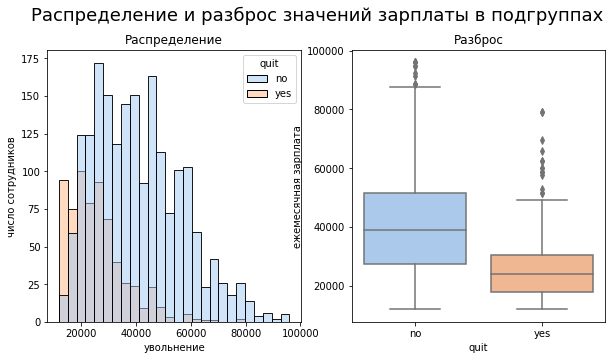

In [86]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('Распределение и разброс значений зарплаты в подгруппах' , fontsize=18,  y = 1)

sns.histplot(x=train_quit['salary'], hue=train_quit.quit, ax=axs[0])
axs[0].set_title("Распределение")
axs[0].set_xlabel('ежемесячная зарплата')
axs[0].set_ylabel('число сотрудников')

sns.boxplot(y=train_quit.salary, x=train_quit.quit, ax=axs[1])
axs[1].set_title("Разброс")
axs[1].set_ylabel('ежемесячная зарплата')
axs[0].set_xlabel('увольнение')

In [87]:
def count_for_cat_hue(cols):
    for col, ax in zip(cols, axs.ravel()):
        df_proportions = train_quit.groupby(col)['quit'].value_counts(normalize=True).reset_index(name='proportion')

# Create the normalized plot
        sns.barplot(x=col, y='proportion', hue='quit', 
        data=df_proportions, order=train_quit[col].value_counts().index, ax=ax)
        ax.set_ylabel('доля сотрудников')

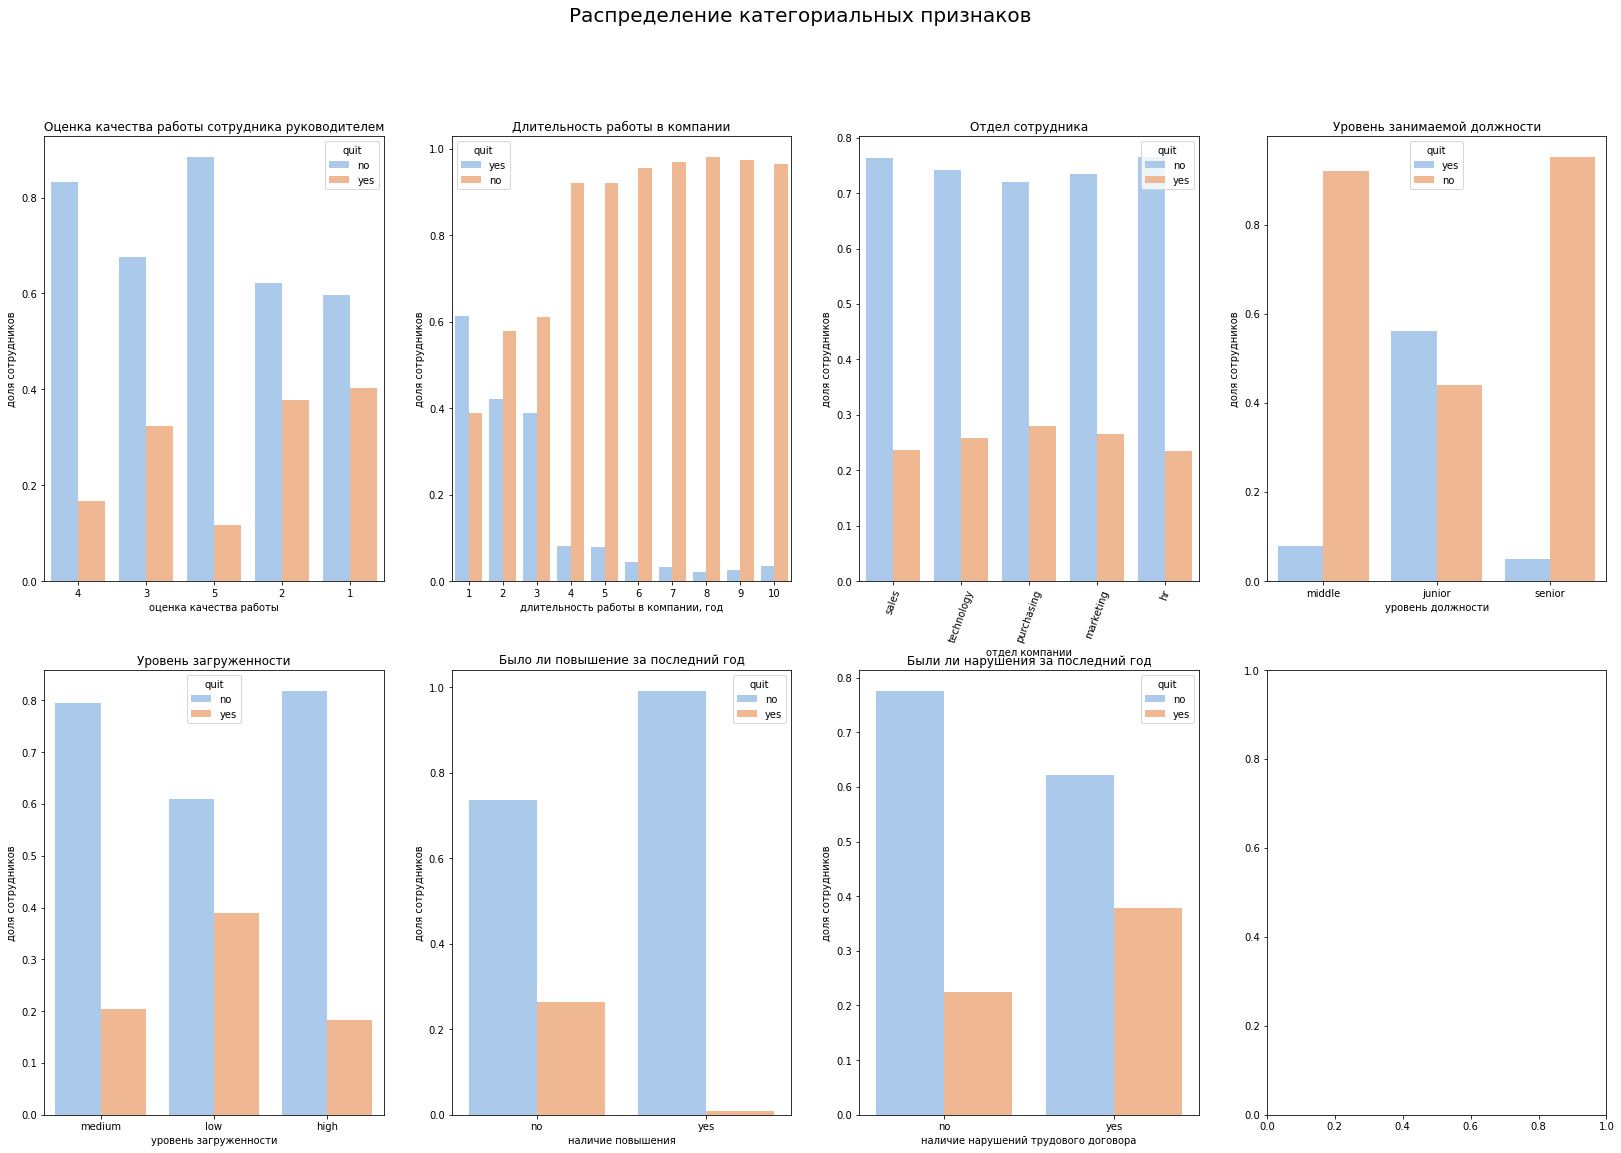

In [88]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(28, 18))
fig.suptitle('Распределение категориальных признаков' , fontsize=20,  y = 0.98)

count_for_cat_hue(['supervisor_evaluation', 'employment_years', 'dept', 'level', 
                   'workload', 'last_year_promo', 'last_year_violations'])
axs[0,1].set_title("Длительность работы в компании")
axs[0,1].set_xlabel("длительность работы в компании, год")

axs[0,0].set_title("Оценка качества работы сотрудника руководителем")
axs[0,0].set_xlabel('оценка качества работы')

axs[0,2].set_xticklabels(train_quit['dept'].value_counts().index,rotation=70);
axs[0,2].set_title("Отдел сотрудника")
axs[0,2].set_xlabel("отдел компании")

axs[0,3].set_title("Уровень занимаемой должности")
axs[0,3].set_xlabel('уровень должности')

axs[1,0].set_title("Уровень загруженности")
axs[1,0].set_xlabel('уровень загруженности')

axs[1,1].set_title("Было ли повышение за последний год")
axs[1,1].set_xlabel('наличие повышения')

axs[1,2].set_title("Были ли нарушения за последний год")
axs[1,2].set_xlabel('наличие нарушений трудового договора');

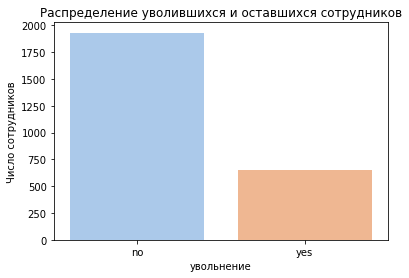

In [89]:
sns.countplot(x='quit', data=train_quit, order=train_quit['quit'].value_counts().index)
plt.title('Распределение уволившихся и оставшихся сотрудников')
plt.xlabel('увольнение')
plt.ylabel('Число сотрудников');

Уволившиеся сотрудники в отличие от тех, кто продолжили работать в компании:
- в большинстве случаев работают в компании 1-3 лет
- получают более низкую зарплату

- Из каждого отдела увольняется количество сотрудников пропорциональное общему числу сотрудников в отделе.
- Чаще всего увольняются специалисты уровня junior, с низким уровнем загруженности.
- Уволившиеся сотрудники, скорее всего, не получали повышение за последний год.

Целевой признак - класс уволен/не уволен не сбалансирован. Уволенных сотрудников в выборке более чем в половину меньше.

In [90]:
train_quit.drop('id', axis=1).groupby('quit').agg('mean').salary

quit
no     40952.173913
yes    25767.938931
Name: salary, dtype: float64

#### 2.2.1 Портрет уволившегося сотрудника
Принимая во внимание вышенаписанное, для уволившегося сотрудника характерно:
- работал в компании недолго (около 1 года), на junior-должности
- уровень загруженности низкий
- получал зарплату около 25 тыс. (что в 1.5 раза меньше, чем у сотрудников продолживших карьеру в компании)
- не получал повышение за последний год работы

#### 2.2.2 Влияние уровня удовлетворенности на увольнение

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. 
Для этого воспользуемся данными  с обоими целевыми признаками тестовой выборки.

In [91]:
test_quit = test.merge(test_y_quit, on='id')

In [92]:
test_quit.shape

(2000, 11)

In [93]:
test_quit.sample(5)

,id,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
1447,577775,0.67,purchasing,middle,medium,5,no,no,3,42000,no
418,510750,0.74,hr,junior,low,1,no,no,4,20400,no
1736,948755,0.75,purchasing,junior,low,2,no,no,4,19200,no
842,667606,0.32,purchasing,junior,medium,2,no,no,3,21600,yes
1533,488314,0.64,hr,junior,low,3,no,no,4,13200,yes


In [94]:
test_quit.groupby('quit').job_satisfaction_rate.mean()

quit
no     0.612040
yes    0.387713
Name: job_satisfaction_rate, dtype: float64

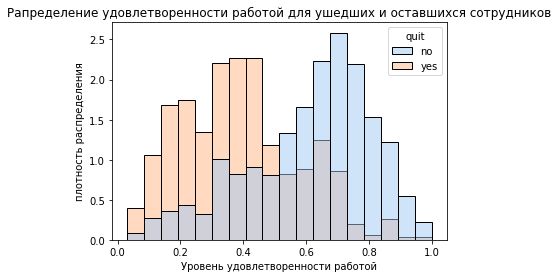

In [95]:
sns.histplot(x=test_quit['job_satisfaction_rate'], hue=test_quit['quit'], stat='density', common_norm=False)
plt.title('Рапределение удовлетворенности работой для ушедших и оставшихся сотрудников')
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('плотность распределения');


Проверим достоверно ли эта разница с точки зрения статистики. 

Нулевая гипотеза - средние уровни удовлетворенности двух классов не отличаются.

Альтернативная - Уровень удовлетворенности оставшихся сотрудников выше, чем у уволившихся.

In [96]:
alpha = 0.01 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(test_quit[test_quit['quit']=='no']['job_satisfaction_rate'], 
                       test_quit[test_quit['quit']=='yes']['job_satisfaction_rate'],
                      alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 6.155610332585965e-105
Отвергаем нулевую гипотезу


Действительно, уровень удовлетворенности у уволившихся сотрудников был статистически значимо ниже, чем у оставшихся. Его среднее значение составило 0.39, в то время как для оставшихся сотрудников - 0.61. 

#### 2.2.3. Добавление признака
Так как уровень удолетворенности влияет на решение уволиться, на основании модели полученной в первой задаче, добавим значения уровня удовлетворенности для записей в тренировочной выборке для второй задачи.

In [97]:
train_quit['job_satisfaction_rate'] = best_reg.predict(train_quit.drop(['id','quit'], axis=1))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [98]:
test_quit['job_satisfaction_rate'] = best_reg.predict(test_quit.drop(['id','quit', 'job_satisfaction_rate'], axis=1))

In [99]:
train_quit.sample(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
3859,590175,purchasing,middle,high,9,no,no,2,56400,no,0.406525
1778,298187,purchasing,middle,high,6,no,no,4,49200,no,0.698585
1327,366406,technology,junior,low,2,no,no,5,19200,no,0.819412


In [100]:
test_quit.sample(2)

,id,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
1727,705147,0.467458,technology,middle,high,2,no,no,3,68400,no
1889,409296,0.376520,technology,senior,medium,10,no,no,3,54000,no


#### 2.2.4. Корреляция по классам

Рассмотрим зависимость признаков с учетом группировки по классам уволился/остался.

Not enough unique value for variable quit for analysis 1. Dropping this column


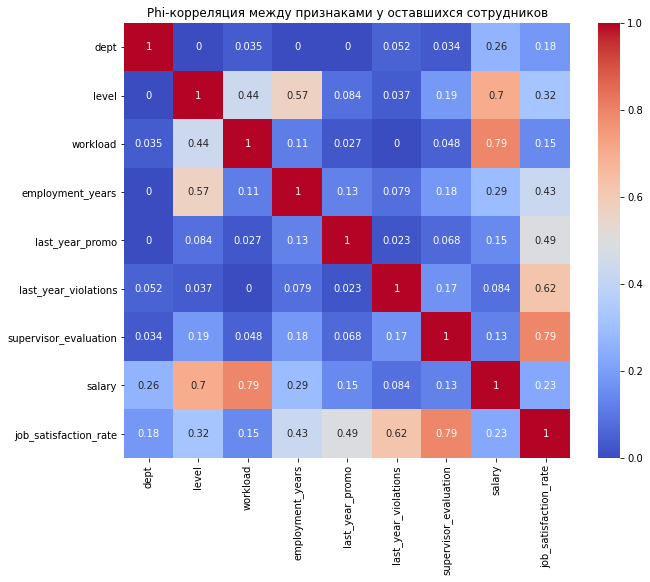

Not enough unique value for variable quit for analysis 1. Dropping this column


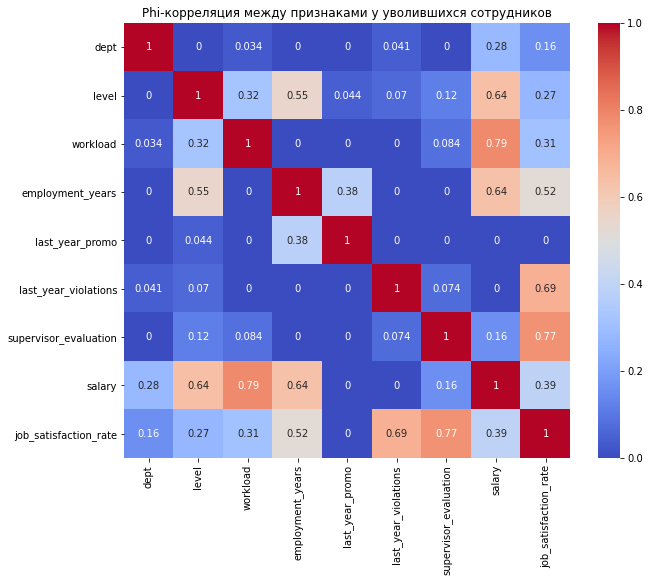

In [101]:
corr_matrix = train_quit[train_quit['quit']=='no'].drop(columns=['id']) \
.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi-корреляция между признаками у оставшихся сотрудников')
plt.show();

corr_matrix1 = train_quit[train_quit['quit']=='yes'].drop(columns=['id']) \
.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title('Phi-корреляция между признаками у уволившихся сотрудников')
plt.show();

Для обеих групп характерно:
- сильная зависимость зарплаты от загруженности и умеренная - от количество лет в компании

Для группы оставшихся в компании сотрудников характерно:
- более значимая зависимость зарплаты от уровня должности
- удовлетворенность зависит от наличия повышения за последний год

Для группы уволившихся сотрудников характерно:
- более значимая зависимость зарплаты от уровня удовлетворенности, чем у оставшихся сотрудников

### 2.3 Построение классификатора

#### 2.3.1 Подготовка данных

Вторая задача состоит в том, чтобы построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании. Это задача классификации.

Таргет - признак `quit`, уволился сотрудник или остался.

Входных признаков 9, в том числе уровень удовлетворенности работой.

Так же как в первой задаче, для бинарных категориальных признаков применим OHE, для отдела сотрудника и ранговых признаков применим - OrdinalEncoder. Масштабировать количественные данные будем с помощью StandardScaler или MinMaxScaler. Кроме того, заменим пропуски (они есть в тестовой выборке) на самые распространенные значения с помощью SimpleImputer. Воспользуемся готовыми пайплайнами.

Оценим качество разбиения на классы с помощью ROC-AUC для классификаторов логистической регрессии, дерева решений, SVC, KNN и выберем лучшую (самую точную) модель. 

Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке. 

In [102]:
X_train = train_quit.drop(columns=['quit','id'])
y_train = train_quit['quit']

label = LabelEncoder()
y_train = label.fit_transform(y_train)

In [103]:
ohe_columns = ['last_year_promo','last_year_violations']
rang_ord_columns = ['level', 'workload']
ord_columns = ['dept']
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate', 'supervisor_evaluation']

In [104]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('rang_ord',rang_ord_pipe, rang_ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

- итоговый пайплайн: подготовка данных и модель

In [105]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=random_state))
    ]
)

#### 2.3.2 Базовый классификатор

In [106]:
pipe_final.fit(X_train, y_train)

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
       



#### 2.3.3 Подбор лучшего классификатора

Подберем лучший классификатор в ходе RandomizedSearchCV.

In [107]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 20),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=random_state)],
        'models__max_depth': range(2, 8),
        'models__min_samples_split': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=random_state, probability=True)],
        'models__kernel': ['rbf', 'poly', 'sigmoid'],
        'models__degree': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(penalty='l1',solver='saga', random_state=random_state)],
        'models__C': np.arange(0, 10, 0.5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [108]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=random_state,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
            

In [109]:
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучший классификатор и его параметры:\n\n', randomized_search.best_estimator_) 

Метрика ROC-AUC для лучшей модели:
 0.9052990790249211

Лучший классификатор и его параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
              

In [110]:
test_quit = test_quit[['id','dept','level','workload','employment_years','last_year_promo', 
                       'last_year_violations','supervisor_evaluation','salary','job_satisfaction_rate', 'quit']]

In [111]:
y_test = label.transform(test_quit.quit)
metrics = metrics.append(clf_metrics(test_quit.drop(['id', 'quit'], axis=1), y_test,randomized_search, 1))
metrics

,clf,roc_auc_CV,roc_auc_test
0,1,0.905299,0.912427


In [112]:
best_clf=randomized_search.best_estimator_

Метрика на тестовой выборке соответствует критерию успеха. Значит данная лучшая модель нам подходит. 

Но попробуем дополнительно улучшить модель за счет удаления неважных признаков. 

Проанализируем важность признаков последней модели:

In [113]:
columns = ['last_year_promo', 'last_year_violations','dept', 'level', 'workload', 'employment_years',
           'salary', 'job_satisfaction_rate', 'supervisor_evaluation'] 

In [114]:
X_train_processed =best_clf['preprocessor'].transform(X_train)                                                                           
permutation = permutation_importance(best_clf['models'], X_train_processed, y_train,scoring = 'roc_auc')

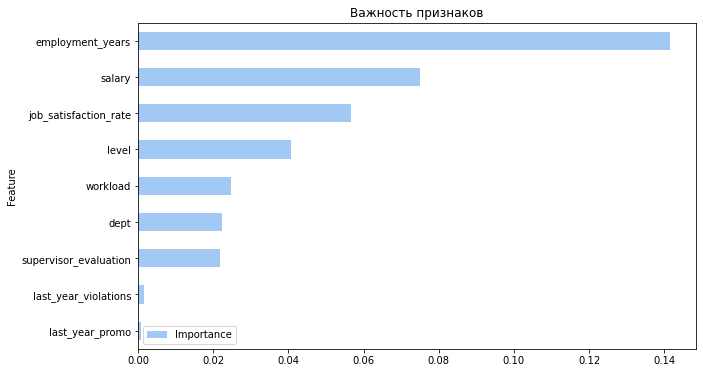

In [115]:
feature_importance = pd.DataFrame({'Feature': columns, 'Importance': permutation['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Важность признаков');

Уберем признак last_year_promo:

In [116]:
X_train = train_quit.drop(columns=['quit','last_year_promo','id'])

In [117]:
ohe_columns = ['last_year_violations']

In [118]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), ohe_columns),
        ('ord', ord_pipe, ord_columns ),
        ('rang_ord',rang_ord_pipe, rang_ord_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [119]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=random_state))
    ]
)

In [120]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=random_state,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               ['last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
        

In [121]:
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучший классификатор и его параметры:\n\n', randomized_search.best_estimator_) 

Метрика ROC-AUC для лучшей модели:
 0.9056968705979578

Лучший классификатор и его параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  un

In [122]:
metrics = metrics.append(clf_metrics(test_quit.drop(['id', 'last_year_promo', 'quit'], axis=1), y_test,randomized_search, 2))
metrics

,clf,roc_auc_CV,roc_auc_test
0,1,0.905299,0.912427
0,2,0.905697,0.911951


На кроссвалидации метрика стала выше, но на тестовой выборке нет.

Уберем признак last_year_violations:

In [123]:
X_train = train_quit.drop(columns=['quit','last_year_violations','id'])

In [124]:
ohe_columns = ['last_year_promo']

In [125]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), ohe_columns),
        ('ord', ord_pipe, ord_columns ),
        ('rang_ord',rang_ord_pipe, rang_ord_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [126]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=random_state))
    ]
)

In [127]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=random_state,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               ['last_year_promo']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
             

In [128]:
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучший классификатор и его параметры:\n\n', randomized_search.best_estimator_) 

Метрика ROC-AUC для лучшей модели:
 0.9045150856132864

Лучший классификатор и его параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['last_year_promo']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown

In [129]:
metrics = metrics.append(clf_metrics(test_quit.drop(['id', 'last_year_violations', 'quit'], axis=1), y_test,randomized_search, 3))
metrics

,clf,roc_auc_CV,roc_auc_test
0,1,0.905299,0.912427
0,2,0.905697,0.911951
0,3,0.904515,0.919242


Оставим как лучший вариант третью модель, для которой показатель ROC-AUC при кроссвалидации равен 0.905, а на тестовой - 0.919. 

Лучший классификатор - DecisionTreeClassifier с параметрами max_depth=4, min_samples_split=5. 

**Проверим модель на адекватность:**

In [130]:
X_train = train_quit.drop(columns=['quit','id'])

pipe_dummy = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DummyClassifier(strategy="prior"))
    ]
)


In [131]:
X_train.sample()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2098,technology,middle,medium,7,no,no,4,39600,0.698985


In [132]:
test_quit.drop(['id', 'quit'], axis=1).sample()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1702,purchasing,middle,high,8,no,no,3,54000,0.477738


In [133]:
pipe_dummy.fit(X_train, y_train)

roc_auc_score(y_test, pipe_dummy.predict_proba(test_quit.drop(['id', 'quit'], axis=1))[:, 1])

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


0.5

Значение ROC-AUC DummyClassifier хуже, чем в лучшем классификаторе. 

#### 2.3.4 Анализ важности признаков

In [134]:
X_train = train_quit.drop(columns=['quit','id'])

In [135]:
classifier = best_clf["models"]
X_train_processed = best_clf["preprocessor"].transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=columns)

X_test_processed = best_clf["preprocessor"].transform(test_quit.drop(columns=['id', 'quit']))
X_test_processed = pd.DataFrame(X_test_processed, columns=columns)


In [136]:
explainer = shap.KernelExplainer(classifier.predict_proba, X_train_processed.sample(100))

In [137]:
shap_values = explainer(X_test_processed[:10])

  0%|          | 0/10 [00:00<?, ?it/s]

Посмотрим важность признаков:

Text(0.5, 1.0, 'Признаки, важные для классификации')

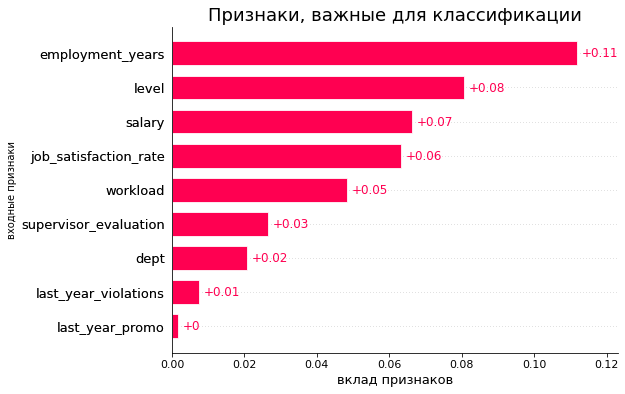

In [138]:
fig, ax = plt.subplots()

shap.plots.bar(shap_values[:,:,1], max_display=16, show=False) 
ax.set_xlabel('вклад признаков')
ax.set_ylabel('входные признаки')
ax.set_title('Признаки, важные для классификации', fontsize=18)

Наиболее важными факторами по которым модель прогнозирует увольнение сотрудника - это удовлетворенность работой, число лет в компании, уровень должности, размер зарплаты, уровень загруженности.

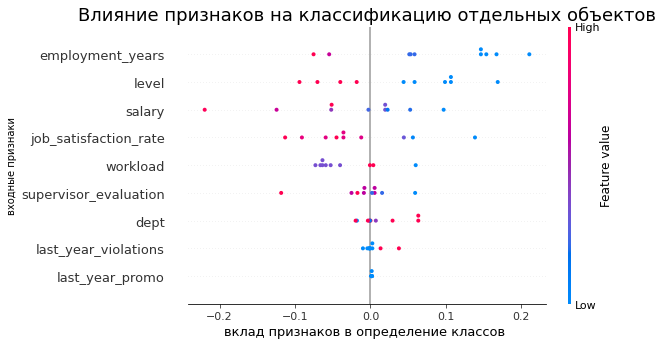

In [139]:
fig, ax = plt.subplots()

shap.plots.beeswarm(shap_values[:,:,1], max_display=16, show=False) 
ax.set_xlabel('вклад признаков в определение классов ')
ax.set_ylabel('входные признаки')
ax.set_title('Влияние признаков на классификацию отдельных объектов', fontsize=18);

При этом, сотрудник вероятнее уволится, если:
- не удовлетворен работой в компании
- получает низкую зарплату и занимает низкую должность
- недавно в компании

#### 2.3.5 Вывод

- Лучший классификатор - модель дерево решений с параметрами max_depth=4, min_samples_split=5. Для масштабирования использован StandardScaler. В тренировочной выборке убрали признак last_year_violations. Выбор сделан на основании наиболее высокой полученной метрике ROC-AUC на тестовой выборке.
- Согласно анализу важности признаков, на увольнение сотрудника прежде всего влияет низкая удовлетворенность работой, маленькая зарплата, низкий уровень занимаемой должности. Новые сотрудники не задерживаюся в компании.

## 3. Итоговый вывод исследования
### Задача 1 - прогноз уровня удовлетворенности сотрудников

1. **Обзор данных**
- Данные для первой задачи представлены в трех таблицах и соответствуют описанию задачи: в одной таблице данные для обучения модели, в остальных двух - для итогового тестирования качества модели.
- В столбцах с входными признаками в столбцах `dept` и `level` есть несколько пропусков, которые заполним при подготовке данных непосредственно перед обучением модели с помощью SimpleImputer. 

2. **Предобработка данных**

В ходе предобработки:
- Единичные пропуски присутствуют в данных тренировочной и тестовой выборки в столбцах `dept`, `level`, `workload`.
- Убрали опечатку в столбце `level`.
- Обнаружили 245 дубликатов записей в тренировочной датасете, их удалили.

3. **Исследовательский анализ данных**

- Все признаки распределены реалистично. Аномалий и выбросов не обнаружено.
- В компании много новых сотрудников (работают 1-3 года), и сильно меньше сотрудников-"старожилов" (6-10 лет в компании)
- Большинство сотрудников работают удовлитворительно (оценка 3) или хорошо (оценка 4) по мнению руководителей. Меньше всего сотрудников, которых руководитель оценил минимально по шкале от 1 до 5.
- Большинство сотрудников получают зарплату в размере 20-40 тыс.
- Уровень удовлетворенности сотрудников в среднем составляет около 0.6. 
- Большая часть сотрудников работают в отделе продаж или в технологической отделе, занимают junior или middle должность, а также имеют средний или низкий уровень загруженности.
- Распределение категориальных и количественных данных имеет схожие паттерны в тестовой и тренировочной выборках, что благоприятно для построения качественной модели.

4. **Корреляционный анализ**

- Мультиколлинеарных признаков нет.
- Зарплата положительно зависит от уровня занимаемой должности и уровня загруженности.
- Удовлетворенный сотрудник реже нарушает трудовой договор и его работа положительно оценивается руководителем.

5. **Регрессионная модель**

- Для решения задачи необходимо было построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. В пайплайнах провели подготовку данных  и обучили модель. 
- Для бинарных категориальных признаков применили OHE, для отдела сотрудника и ранговых признаков применим - OrdinalEncoder. Масштабировали количественные данные с помощью StandardScaler или MinMaxScaler. Кроме того, заменили пропуски на самые распространенные значения с помощью SimpleImputer. В подборе использовали несколько моделей с подбором гиперпараметров -  линейную регрессию, регрессионное дерево решений и случайный лес. 
- Оценивали качество моделей собственной метрикой SMAPE - симметричное среднее абсолютное процентное отклонение (ошибка модели, принимающая только положительные значения). Чем меньше ошибка, тем лучше качество модели.
- Критерию успеха (SMAPE ≤15 на тестовой выборке) соотвествует ансамбль моделей RandomForest с параметрами max_depth=14, min_samples_split=4, n_estimators=125 и методом масштабирования StandardScaler. В случае этой модели, SMAPE на валидационной выборке равна 13.8, на тестовой - равна 12.5. Это лучшие показатели полученные в ходе RandomizedSearchCV. Адекватность лучшей модели проверена с помощью DummyRegressor.
- Наиболее важные признаки, влияющие на удовлетворенность сотрудника - оценка работы сотрудника руководителем, количество лет в компании, зарплата. Удовлетворенность сотрудника работой в компании выше, если его хорошо оценивает руководитель, он уже долго работает в компании, получает не самую низкую зарплату, имеет невысокую загруженность, получает повышение.

### Задача 2 - прогноз увольнения сотрудников из компании

1. **Обзор данных**

Данные для второй задачи также представлены в трех таблицах и соответствуют описанию задачи: в одной таблице данные для обучения модели, в остальных двух - для итогового тестирования качества модели.

2. **Предобработка данных**

Проверили все как и в первой задаче, устранили ту же опечатку. В новой обучающей выборке пропусков нет, удалили 1413 дубликатов строк.

3. **Исследовательский анализ данных**

На основании распределения признаков в классах уволившихся и оставшихся сотрудников, составлен портрет уволившегося сотрудника. Для него характерно:
- работал в компании недолго (около 1 года), на junior-должности
- уровень загруженности низкий
- получал зарплату около 24 тыс. (что в 1.5 раза меньше, чем у сотрудников продолживших карьеру в компании)
- не получал повышение за последний год работы

Кроме того, было показано, что уровень удовлетворенности у уволившихся сотрудников был статистически значимо ниже, чем у оставшихся. Его среднее значение составило 0.39, в то время как для оставшихся сотрудников - 0.61. 

На основании предсказаний первой модели к обучающим данным был добавлен признак уровня удовлетворенности.


4. **Модель классификации**

- Для решения задачи необходимо было построить модель, которая сможет предсказать уволиться сотрулник или нет. В пайплайнах провели подготовку данных  и обучили модель. Были использованы те же методы подготовки данных, что и в первой задаче.
- Оценивали качество разбиения на классы с помощью ROC-AUC для классификаторов логистической регрессии, дерева решений, SVC, KNN.
- Лучший классификатор - модель DecisionTreeClassifier с параметрами max_depth=4, min_samples_split=5, для которой показатель ROC-AUC при кроссвалидации равен 0.905, а на тестовой - 0.919, подходит под критерий качества модели ROC-AUC ≥ 0.91 на тесте. Для масштабирования использован StandardScaler. Для входных данных без признака last_year_violations. Выбор сделан на основании наиболее высокой полученной метрике ROC-AUC на тестовой выборке. Адекватность лучшей модели проверена с помощью DummyClassifier.
- Согласно анализу важности признаков, на увольнение сотрудника прежде всего влияет низкая удовлетворенность работой, маленькая зарплата, низкий уровень занимаемой должности. Новые сотрудники не задерживаются в компании, вероятно не могут преодолет порог вхождения в компанию.

На основе данного анализа уровня удовлетворенности сотрудников и их оттока из компании можно предложить следующие возможные решения для повышения уровня удовлетворенности и снижения оттока сотрудников из компании:

- сделать начало работы в компании более комфортным для новых сотрудников. Например, за счет менторства или каких-либо бонусов для новых сотрудников.
- по возможности, увеличить зарплату, вероятно на основании оценки руководителя.
- регулярно давать объективную положительную обратную связь сотруднику о его работе и не пренебрегать повышением
- загружать работой согласно возможностям сотрудника (не перенагружать, но и не недогружать).